# Reinforcement Learning with Cryptodata

In [13]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from reinforcement_learning.agent.agent import Agent
from reinforcement_learning.functions import *

py.init_notebook_mode(connected=True)

## load Data

In [14]:
data_full = pd.read_csv('artifacts/data_full.csv')
#data_full['Date'] = pd.to_datetime(data_full['Date'])
data_full['Date'] = [pd.to_datetime(str(x) + ' 00:00:00',format = '%Y-%m-%d %H:%M:%S') for x in data_full['Date']] 
for x in data_full['Date'][:10]:
    print(str(x))
data_full = data_full.set_index('Date')
data_full.index = pd.to_datetime(data_full.index,format = '%Y-%m-%d %H:%M:%S')
data_full.index[:10]

2016-07-25 00:00:00
2016-07-26 00:00:00
2016-07-27 00:00:00
2016-07-28 00:00:00
2016-07-29 00:00:00
2016-07-30 00:00:00
2016-07-31 00:00:00
2016-08-01 00:00:00
2016-08-02 00:00:00
2016-08-03 00:00:00


DatetimeIndex(['2016-07-25', '2016-07-26', '2016-07-27', '2016-07-28',
               '2016-07-29', '2016-07-30', '2016-07-31', '2016-08-01',
               '2016-08-02', '2016-08-03'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [18]:

window_size = 5
episode_count = 5
add_mean = False
#
if add_mean:
    agent = Agent(window_size + 1)
else: 
    agent = Agent(window_size)
data = data_full['BTC'][1000:]
#print(data)
l = len(data) - 1
batch_size = 32
#getState()
budget_start = 20000
budget_start = np.max(data) * len(data)

profits = []
for e in range(episode_count + 1):
    
    states_sell = []
    states_buy = []
    
    budget = budget_start
    print("Episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    
    if add_mean:
        a = [i for j in state for i in j]
        a.append(0)
        state = np.array([a])
    total_profit = 0
    agent.inventory = []
    
    for t in range(l):
        if t == 0:
            agent.inventory.append(data[t])
            budget -= data[t]
            states_buy.append(t)
            mean_price = data[t]
            # wenn gekauft, dann ist Reward Preisunterschied zum vorherigen Preis
            reward = mean_price #- data[t]
            print("Buy: " + formatPrice(data[t]))
        else:
            #print(t)
            action = agent.act(state)

            # sit
            next_state = getState(data, t + 1, window_size + 1)
            #reward = - np.min(data)#/10
            reward = 0

            if t != 0 and t > int(window_size/2):
                mean_price = np.mean(data[(t - int(window_size/2)):(t-1)])  
            elif t > 1:
                mean_price = np.mean(data[0:(t-1)]) 
            else:
                mean_price = data[0]

            if action == 1 and np.sum(agent.inventory) + data[t] <= budget: # buy
                agent.inventory.append(data[t])
                budget -= data[t]
                states_buy.append(t)
                # wenn gekauft, dann ist Reward Preisunterschied zum vorherigen Preis
                #reward = mean_price - data[t]
                print("Buy: " + formatPrice(data[t]))

            elif action == 2 and len(agent.inventory) > 0:# and data[t] > mean_price: # sell
                bought_price = agent.inventory.pop(0)
                reward = max(data[t] - bought_price, 0)
                #reward = data[t] - bought_price
                total_profit += data[t] - bought_price
                budget += data[t] 
                states_sell.append(t)
                print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

                #agent.inventory.append(data[t])
                #print("Sell: " + formatPrice(data[t]) + " | Profit: " + str(round(np.sum(agent.inventory),2)))

            # Verluste stärker bestrafen(penalty_factor > 1) bzw. geringer zu bestrafen (1 > penalty_factor > 0):
            # dank relu ohne effekt
            penalty_factor = 1
            if reward < 0:
                reward = reward * penalty_factor

            done = True if t == l - 1 else False
            if add_mean:
                a = [i for j in next_state for i in j]
                a.append(mean_price/1000)
                next_state = np.array([a])
                
            #if t <= 100: print('State: '  + str(state))
            
 
            
            agent.memory.append((state, action, reward, next_state, done))
            state = next_state

            if done:
                print("--------------------------------")
                print("Total Profit: " + formatPrice(total_profit))
                print("Final Budget: " + formatPrice(budget))
                print("--------------------------------")
                profits.append(total_profit)

            if len(agent.memory) > batch_size:
                #print('Learn!')
                agent.expReplay(batch_size)

    if e % 1 == 0:
        try: 
            os.mkdir('models')
        except:
            pass
        agent.model.save("models/model_ep" + str(e))
    
    try: 
        os.mkdir('models/plots')
    except:
        pass
    
    
    figure = "models/plots/model_ep{}.png".format(str(e))
    plt.figure(figsize = (20, 10))
    plt.plot(data, label = 'BTC/USDT', c = 'black')
    plt.text(np.min(data.index),np.max(data),'Profit:{}'.format(round(total_profit,0)))
    plt.title('When to buy and sell Bitcoins')
    plt.plot(data, 'o', label = 'predict buy', markevery = states_buy, c = 'g')
    plt.plot(data, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
    plt.legend()
    plt.savefig(figure)
    
    if (e + 1) % 5 == 0:
        pd.Series(profits).plot()
        plt.show()


Episode 0/5
Buy: $5506.78
Sell: $5523.84 | Profit: $17.05
Buy: $5152.54
Buy: $5150.28
Sell: $5149.15 | Profit: -$3.38
Sell: $5148.02 | Profit: -$2.26
Buy: $5218.46
Sell: $5533.88 | Profit: $315.41
Buy: $5770.44
Buy: $5809.86
Sell: $5829.58 | Profit: $59.14
Buy: $5839.43
Sell: $5849.29 | Profit: $39.43
Buy: $6045.30
Sell: $6295.32 | Profit: $455.89
Sell: $7308.42 | Profit: $1263.12
Buy: $7990.38
Buy: $8062.63
Sell: $7983.74 | Profit: -$6.64
Sell: $7196.20 | Profit: -$866.44
Buy: $7721.84
Sell: $8012.59 | Profit: $290.75
1/1 [==============================] - 0s 28ms/step
Buy: $8350.83
1/1 [==============================] - 0s 22ms/step
Sell: $8519.95 | Profit: $169.12
1/1 [==============================] - 0s 26ms/step
Buy: $8689.06
1/1 [==============================] - 0s 24ms/step
Sell: $8559.94 | Profit: -$129.13
1/1 [==============================] - 0s 22ms/step
Buy: $8434.40
1/1 [==============================] - 0s 27ms/step
Sell: $7800.38 | Profit: -$634.03
1/1 [===============

KeyboardInterrupt: 

In [ ]:
pd.Series(profits).plot()
pd.Series(profits).mean()


0.9706877692486436

In [ ]:
print(next_state.tolist())
a = [i for j in next_state for i in j]
print(a)
a.append(3.0)
print(np.array([a]))
#next_state = np.append(next_state,3)
#print(next_state)

--------------------------------
 Total Profit: $0.00
--------------------------------


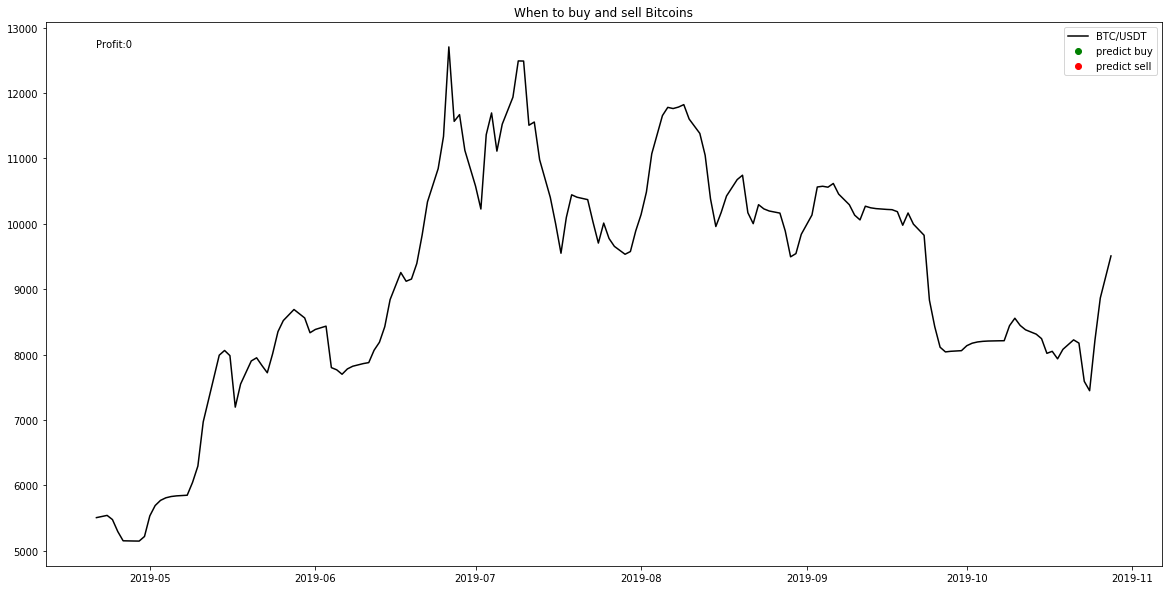

In [ ]:
import keras
from keras.models import load_model

#from agent.agent import Agent
#from functions import *
import sys

#stock_name, 
model_name = 'model_ep0'
model = load_model("models/" + model_name)
window_size = model.layers[0].input.shape.as_list()[1]

agent = Agent(window_size, True, model_name)
data = data
l = len(data) - 1
batch_size = 32

budget_start = 20000

state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

states_sell = []
states_buy = []

for t in range(l):
    action = agent.act(state)

    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0
    
    mean_price = np.mean(data[0:t]) if t != 0 else data[0]
        
    if action == 1 and np.sum(agent.inventory) + data[t] <= budget: # buy
        agent.inventory.append(data[t])
        budget -= data[t]
        states_buy.append(t)
        print("Buy: " + formatPrice(data[t]))

    elif action == 2 and len(agent.inventory) > 0 and data[t] > mean_price: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        budget += data[t] 
        states_sell.append(t)
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))
        
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("--------------------------------")
        print(" Total Profit: " + formatPrice(total_profit))
        print("--------------------------------")

if len(agent.memory) > batch_size:
    agent.expReplay(batch_size)        

#figure = "models/plots/model_ep{}.png".format(str(e))
plt.figure(figsize = (20, 10))
plt.plot(data, label = 'BTC/USDT', c = 'black')
plt.text(np.min(data.index),np.max(data),'Profit:{}'.format(round(total_profit,0)))
plt.title('When to buy and sell Bitcoins')
plt.plot(data, 'o', label = 'predict buy', markevery = states_buy, c = 'g')
plt.plot(data, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
plt.legend()
#plt.savefig(figure) 

In [ ]:
# Liste in Wertebereich pressen:
a = [10,15,20,30,50,90]

def pushtogether(lst, minmax = 20):
    import numpy as np
    b = (a - np.nanmean(a))/ np.sqrt(np.var(a))
    relation = minmax/max(b)
    b = b * relation
    return(b)

pushtogether(a)